In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import GPy
import GPyOpt

## Introduction
In the following, we tune the hyperparameters for logistic regression on the MNIST dataset. The tuning is performed by Bayesian optimisation. 

## Import MNIST data

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Choosing n_iter for SGDClassifier is deprecated but we need it to reproduce our result
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [5]:
# Load dataset and make sure to shuffle it
mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
y = mnist.target
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [128]:
print("Size of data = {}".format(X.shape))

Size of data = (70000, 784)


In [129]:
train_samples = 5000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [130]:
X_train.shape

(5000, 784)

## Define model and search space

Four hyperparameter to tune:
 1. Learning rate for SGD $\in [0,1]$ (log scale)
 2. $l_2$ regularisation parameter $\in [0,1]$
 3. Number of learning epochs $\in [5,2000]$
 4. Mini-batch size $\in [20,2000]$
 

In [8]:
def next_batch(X, y, batch_size):
    for i in np.arange(0, X.shape[0], batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])

In [134]:
classes = np.unique(y)
gamma = 0.05                    # learning rate
alpha = 50. / train_samples     # l2 regulariser
n_iter = 100                    # learning epochs
batch_size = 200                # mini batch size

clf = SGDClassifier(loss = 'log',
                    penalty = 'l2',
                    alpha = alpha,
                    learning_rate = 'constant',
                    eta0 = gamma,
                    n_iter = 1)

In [139]:
start = time.time()
for i in range(n_iter):
    for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
        clf.partial_fit(X_batch, y_batch, classes=classes)
end = time.time()

sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)
print("Time elapsed: {}".format(end-start))

Sparsity with L2 penalty: 14.29%
Test score with L2 penalty: 0.7825
Time elapsed: 14.0815160275


## Wrapper function for scoring model

In [177]:
def fit_svr_val(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        gamma = np.exp(x[i,0]) # log scale
        alpha = np.exp(x[i,1]) # log scale
        n_iter = int(x[i,2])
        batch_size = int(x[i,3])
        clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, 
                            learning_rate='constant', eta0=gamma, 
                            n_iter=1)
        for j in range(n_iter):
            for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
                clf.partial_fit(X_batch, y_batch, classes=classes)

        score = clf.score(X_test, y_test)
        fs[i] = 1 - score # classification error
    return fs

In [178]:
x = np.array([-2, np.log(50 / train_samples), 100, 200])
start = time.time()
print(fit_svr_val(x))
end = time.time()
print("Time elapsed: {}".format(end-start))

[[ 0.1699]]
Time elapsed: 14.2131769657


## Bayesian Optimisation

In [246]:
opt_iter = 50

In [247]:
domain =      [{'name': 'gamma_log','type': 'continuous', 'domain': (-6,0)}, 
               {'name': 'alpha_log','type': 'continuous', 'domain': (-6,0)},
               {'name': 'n_iter','type': 'discrete', 'domain': (5,100)},
               {'name': 'batch_size','type': 'discrete', 'domain': (20,2000)}]

In [248]:
n_dim = len(domain)
n_initial = 5 * n_dim
bayes_opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,                   
                                                domain = domain, 
                                                model_type = 'GP',
                                                acquisition_type = 'EI',
                                                exact_feval = True,
                                                initial_design_numdata = n_initial, 
                                                initial_design_type = 'random',
                                                num_cores = 2)   

In [249]:
X_init = bayes_opt.X
Y_init = bayes_opt.Y
print(X_init.shape)

(20, 4)


In [250]:
start = time.time()
bayes_opt.run_optimization(max_iter = opt_iter)
end = time.time()
print("Time elapsed: {}".format(end-start))

Time elapsed: 884.545397997


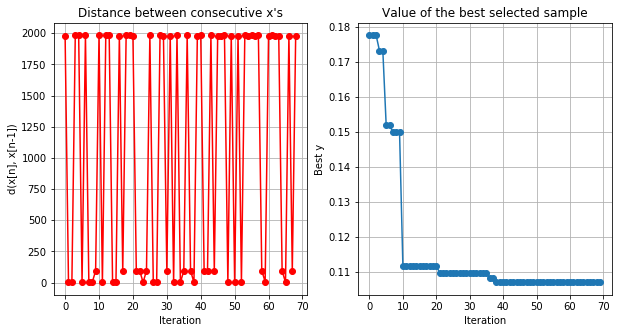

In [251]:
bayes_opt.plot_convergence()

In [252]:
min_index = np.argmin(bayes_opt.Y)
x_best = bayes_opt.X[min_index,:]
y_best = bayes_opt.Y[min_index,:]

print(x_best)
print(y_best)

[  -6.          -4.5411952  100.          20.       ]
[ 0.107]


In [253]:
# Test candidate on the true objective
print(fit_svr_val(x_best))

[[ 0.1068]]


In [254]:
bayes_opt.save_report("mnist")

## Compare with random search

In [255]:
class RandomOptimiser():
    def __init__(self, f, domain, X_init, Y_init):
        self.f = f
        self.domain = domain
        self.X = X_init
        self.Y = Y_init
    def run_optimization(self, n_iters):
        from GPyOpt.experiment_design import initial_design
        from GPyOpt.util.general import best_value
        X_new = initial_design('random', self.domain, n_iters)
        Y_new = np.zeros((n_iters))
        
        assert(self.X.shape[1] == X_new.shape[1])
        self.X = np.concatenate((self.X, X_new))
        Y_best_global = np.min(self.Y)
        
        for i in range(n_iters):
            X_current = X_new[i,:]
            Y_current = self.f(X_current)
            if Y_current < Y_best_global:
                Y_best_global = Y_current
            Y_new[i] = Y_current

        self.Y = np.append(self.Y, Y_new)
        self.Y_best = best_value(self.Y)

In [256]:
random_opt = RandomOptimiser(f = fit_svr_val,
                             domain = bayes_opt.space, 
                             X_init = X_init, 
                             Y_init = Y_init)

In [257]:
start = time.time()
random_opt.run_optimization(n_iters=opt_iter)
end = time.time()
print("Time elapsed: {}".format(end-start))

Time elapsed: 831.519360065


In [258]:
min_index = np.argmin(random_opt.Y)
x_best_random = random_opt.X[min_index,:]
y_best_random = random_opt.Y[min_index]

print(x_best_random)
print(y_best_random)

[   -5.91370985    -4.85306212   100.          2000.        ]
0.1073


In [259]:
fit_svr_val(x_best_random)

array([[ 0.1104]])

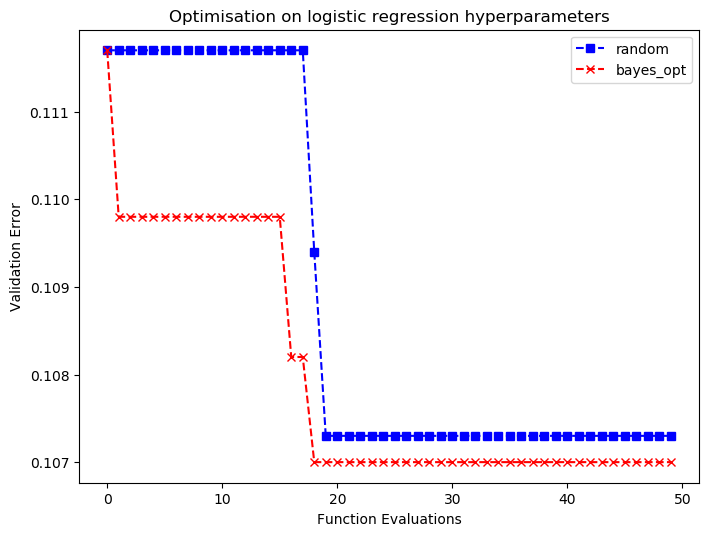

In [262]:
# Initialise plot
fig,ax = plt.subplots(1,1, figsize=(8, 6), dpi=100)
num_iter_random = len(random_opt.Y) - n_initial
num_iter_bayes = len(bayes_opt.Y) - n_initial
ax.plot(range(num_iter_random), random_opt.Y_best[n_initial:], '--bs', label='random')
ax.plot(range(num_iter_bayes), bayes_opt.Y_best[n_initial:], '--rx', label='bayes_opt')
plt.title('Optimisation on logistic regression hyperparameters')
plt.ylabel('Validation Error'); plt.xlabel('Function Evaluations');
plt.legend()